<a href="https://colab.research.google.com/github/6yuvaldavid/Anomaly-Detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds

%matplotlib inline
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
img_height = 28
img_width = 28
batch_size = 30

In [3]:
import pathlib
data_dir = 'data'
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*.png')))
print(image_count)

100


In [5]:
roses = list(data_dir.glob('*.png'))
PIL.Image.open(str(roses[1]))

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = None,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 1 classes.


In [7]:
x_val = np.concatenate([x for x in val_ds], axis=0)
x_val = x_val.astype('float32') / 255.

In [8]:
latent_dim = 128 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(2352, activation='sigmoid'),
      layers.Reshape((28, 28, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [9]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

import numpy as np

train_mask = np.isin(Y_train, [1, 2])
test_mask = np.isin(Y_test, [1, 2])

print(len(X_train))

X_train = X_train[train_mask]
X_test = X_test[test_mask]

X_train = X_train / 255.


# Set reshaped array to X 
X_train = X_train.reshape(len(X_train), 28, 28, 1)

# Convert images and store them in X3
X3 = tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(X_train)
)

X_test = X_test / 255.

# Set reshaped array to X 
X_test = X_test.reshape((len(X_test), 28, 28, 1))

# Convert images and store them in X3
X4 = tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(X_test)
)
print(len(X_test))

60000
2167


In [11]:
autoencoder.fit(X3, X3,validation_data=(X4, X4),
                epochs=20)

Epoch 1/20
397/397 [==============================] - 4s 9ms/step - loss: 0.0311 - val_loss: 0.0142
Epoch 2/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0109 - val_loss: 0.0080
Epoch 3/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 4/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 5/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 6/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/20
397/397 [==============================] - 3s 8ms/step - loss: 0.0023 - val_loss: 0.0025

In [12]:
encoded_imgs = autoencoder.encoder(x_val).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

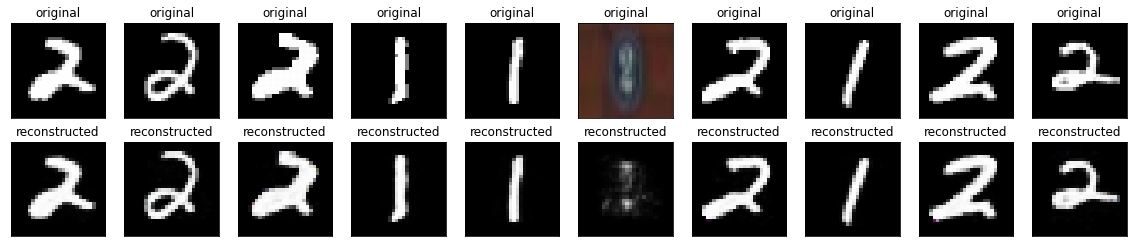

In [28]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_val[i+50])
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i+50])
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
encoded_data = autoencoder.encoder(x_val).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [15]:
reconstructions = autoencoder.predict(x_val)
train_loss = tf.keras.losses.mae(reconstructions, x_val)

In [16]:
loss = tf.reduce_sum(train_loss, 2).numpy()

In [17]:
loss = loss.sum(axis=1)

In [21]:
indices = (-loss).argsort()[0:20]

In [22]:
indices

array([60, 76, 46, 29,  3, 10, 24,  0, 55,  6, 78, 27, 32, 20, 52, 31, 26,
       95, 16, 35])

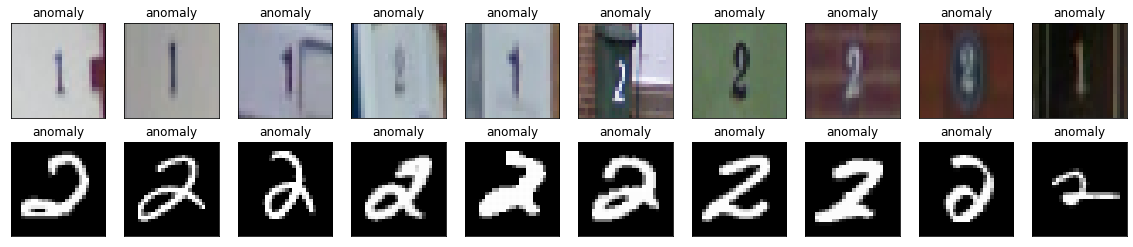

In [23]:
n = 100
t=1
plt.figure(figsize=(20, 4))
for i in indices:
  # display reconstruction
    
  ax = plt.subplot(2, 10, t)

  plt.imshow(x_val[i])
  plt.title("anomaly")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  t+=1
plt.show()

In [24]:
loss[indices]

array([444.7636  , 423.2162  , 414.1418  , 394.1075  , 379.54968 ,
       314.4908  , 271.94443 , 185.92706 , 146.56766 ,  77.604355,
        19.83653 ,  19.743391,  19.44361 ,  19.168915,  18.609058,
        17.217167,  16.924747,  16.709694,  16.614084,  16.360296],
      dtype=float32)